In [1]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [2]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [4]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [5]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [6]:
# load the dataset
series = read_csv("trafficnew.csv", header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

In [9]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 500)
print('MAE: %.3f' % mae)

>expected=262.5, predicted=199.5
>expected=287.7, predicted=405.7
>expected=373.6, predicted=239.7
>expected=69.4, predicted=744.5
>expected=18.2, predicted=214.2
>expected=1262.8, predicted=121.9
>expected=148.6, predicted=494.4
>expected=590.6, predicted=124.1
>expected=541.5, predicted=396.4
>expected=142.4, predicted=369.9
>expected=67.3, predicted=182.4
>expected=6.1, predicted=835.8
>expected=24.5, predicted=249.7
>expected=60.2, predicted=396.7
>expected=188.0, predicted=66.4
>expected=1.2, predicted=129.6
>expected=7.6, predicted=151.4
>expected=136.0, predicted=102.7
>expected=424.4, predicted=121.3
>expected=20.1, predicted=405.9
>expected=238.5, predicted=104.6
>expected=92.3, predicted=141.3
>expected=53.5, predicted=129.7
>expected=22.9, predicted=80.2
>expected=5.8, predicted=165.3
>expected=8.7, predicted=111.3
>expected=2178.7, predicted=58.8
>expected=5.7, predicted=381.6
>expected=0.0, predicted=363.1
>expected=304.7, predicted=279.6
>expected=260.4, predicted=481.9
>

>expected=61.4, predicted=486.0
>expected=1.3, predicted=214.5
>expected=100.0, predicted=287.3
>expected=0.7, predicted=390.2
>expected=177.4, predicted=56.4
>expected=18.8, predicted=454.5
>expected=31.6, predicted=131.9
>expected=0.9, predicted=128.9
>expected=163.8, predicted=82.9
>expected=335.9, predicted=232.0
>expected=99.1, predicted=101.5
>expected=734.5, predicted=254.6
>expected=210.4, predicted=309.5
>expected=2.0, predicted=147.0
>expected=27.5, predicted=150.7
>expected=0.1, predicted=368.6
>expected=431.1, predicted=115.7
>expected=9.3, predicted=1206.1
>expected=9.8, predicted=182.8
>expected=63.3, predicted=136.9
>expected=1.6, predicted=241.6
>expected=28.8, predicted=115.5
>expected=855.6, predicted=153.9
>expected=2.8, predicted=116.4
>expected=0.6, predicted=67.8
>expected=258.2, predicted=209.4
>expected=196.7, predicted=486.8
>expected=12.1, predicted=252.5
>expected=5.5, predicted=193.7
>expected=0.2, predicted=92.1
>expected=100.1, predicted=130.2
>expected=19

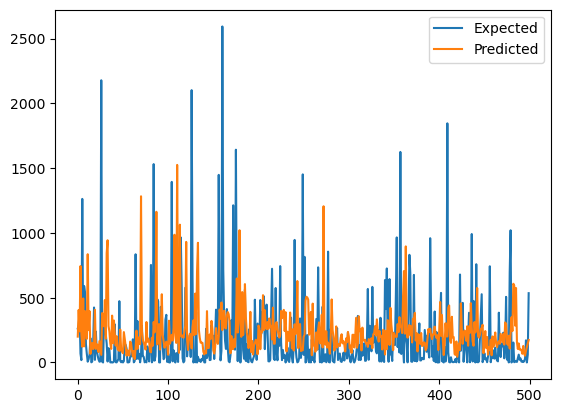

In [10]:
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()